In [35]:
import json
import pandas as pd

In [36]:
attribute_ontology = pd.read_csv('../wish_attr_extract_label/[ontology] wish_top25L2_attributes - 20221219.csv')

In [37]:
l2set = set(attribute_ontology['wish_L2'])

In [38]:
df_tax = pd.read_json('../taxonomy/wish_newtax.json', lines=True)

In [39]:
taxid2path = {}
for i in df_tax.to_dict('records'):
    if len(i['category_path']) > 0:
        taxid2path[i['id']] = i['category_path']

In [40]:
taxpathidset = set(df_tax[df_tax['category_path'].apply(lambda x: any(x.startswith(i) for i in l2set))]['id'])

In [41]:
l2filter = "regexp_like(categories, '{}')".format('|'.join([f'^{num},|,{num},|,{num}$' for num in taxpathidset]))

In [42]:
from tahoe import execute_async


In [44]:
cutoff_dt = '2023-01-10'

In [45]:
execute_async(f"""
SELECT COUNT(*) FROM structured_data.query_top3_predictions
WHERE model_version = 1 AND taxonomy_version = 121 AND dt < '{cutoff_dt}'
""")

[(3178998,)]

In [62]:
q = f"""
SELECT query, categories FROM structured_data.query_top3_predictions
WHERE model_version = 1 AND taxonomy_version = 121 AND dt < '{cutoff_dt}' AND regexp_count(query, ' ') >= 2
AND {l2filter}
LIMIT 10000
"""

In [63]:
res = execute_async(q)


In [64]:
example_queries = pd.DataFrame(res, columns=['query', 'categories']).drop_duplicates('query')

In [65]:
example_queries['l2s'] = example_queries.categories.apply(lambda x: [' > '.join(taxid2path[int(i)].split(' > ')[:2]) for i in x.split(',')])

In [66]:
example_queries['valid_l2s'] = example_queries.l2s.apply(lambda x: [i for i in x if i in l2set])

<AxesSubplot: ylabel='Frequency'>

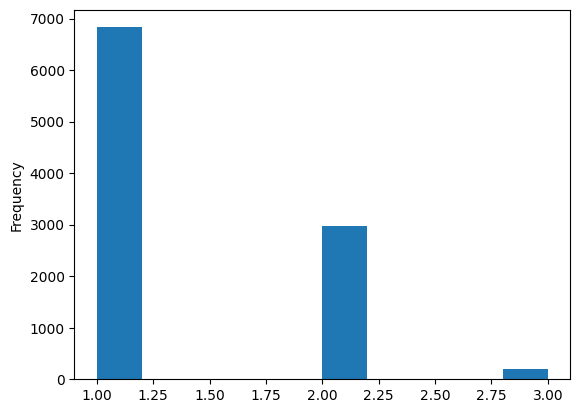

In [67]:
example_queries['valid_l2s'].apply(lambda x: len(set(x))).plot.hist()

In [68]:
example_queries[example_queries.valid_l2s.apply(lambda x: len(set(x)) == 2)][
    ['query', 'valid_l2s']].sample(2).to_dict('records')

[{'query': 'mini rock mushroom',
  'valid_l2s': ['Home & Garden > Home Decor',
   'Home & Garden > Home Decor',
   'Home & Garden > Garden Supplies']},
 {'query': 'glass beads 3mm hole',
  'valid_l2s': ['Home & Garden > Arts, Crafts & Sewing',
   'Home Improvement > Lights & Lighting']}]

In [69]:
example_queries['top_valid_l2'] = example_queries['valid_l2s'].apply(lambda x: x[0])

In [70]:
len(set(example_queries.top_valid_l2))

25

<AxesSubplot: ylabel='top_valid_l2'>

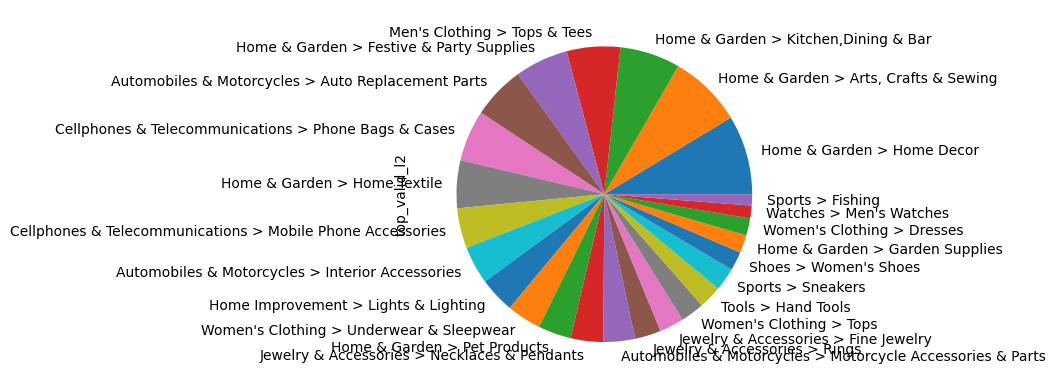

In [71]:
example_queries.top_valid_l2.value_counts().plot.pie()

In [73]:
example_queries.top_valid_l2.value_counts().min(), example_queries.top_valid_l2.value_counts().max()

(123, 867)

In [76]:
sample_example_queries = example_queries.groupby('top_valid_l2').sample(10, random_state=42)

<AxesSubplot: ylabel='top_valid_l2'>

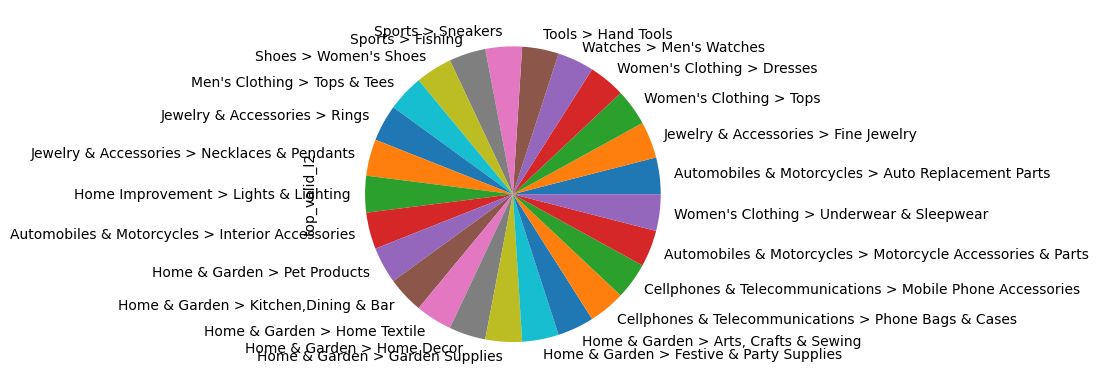

In [78]:
sample_example_queries.top_valid_l2.value_counts().plot.pie()

In [80]:
sample_example_queries[['query', 'top_valid_l2']].to_csv("processed/l2stratified_sample_250_query.csv", index=False)